In [2]:
import pstats
import random as rnd
import numpy as np
from pymoo.visualization.scatter import Scatter
from pymoo.optimize import minimize
from pymoo.core.problem import Problem
from pymoo.core.sampling import Sampling
from pymoo.core.crossover import Crossover
from pymoo.core.mutation import Mutation
from pymoo.algorithms.moo.nsga2 import NSGA2
from pymoo.operators.survival.rank_and_crowding import RankAndCrowding
import warnings
import time
from pymoo.util.ref_dirs import get_reference_directions
import optuna
from pymoo.indicators.hv import HV
import logging
import sys
from sklearn import preprocessing
from itertools import chain
import matplotlib.pyplot as plt

## CARGAR DATOS

In [3]:
# Cargamos las tablas con las notas
for i in range(1, 3):
    for j in range(1, 5):
        # Nombre de la variable
        nombre_variable = f'R{i}{j}'

        # Nombre del archivo CSV
        path = f'Datos/R{i}{j}.csv'
        
        # Cargar la tabla desde el archivo CSV y asignarla a la variable con el nombre correspondiente
        globals()[nombre_variable] = np.loadtxt(path, delimiter=',')
        
        

#Cargamos las tablas con los generos
for i in range(1, 3):
    for j in range(1, 5):
        # Nombre de la variable
        nombre_variable = f'G{i}{j}'

        # Nombre del archivo CSV
        path = f'Datos/G{i}{j}.csv'
        
        # Cargar la tabla desde el archivo CSV y asignarla a la variable con el nombre correspondiente
        globals()[nombre_variable] = np.loadtxt(path, delimiter=',')

Prop_aula_G11 = float(np.mean(G11))
Prop_aula_G12 = float(np.mean(G12))
Prop_aula_G13 = float(np.mean(G13))
Prop_aula_G14 = float(np.mean(G14))
Prop_aula_G21 = float(np.mean(G21))
Prop_aula_G22 = float(np.mean(G22))
Prop_aula_G23 = float(np.mean(G23))
Prop_aula_G24 = float(np.mean(G24))

#Cargamos las tablas con los test MTBI
K=np.loadtxt("Datos/K", delimiter=',')

## CLASES Y FUNCIONES NECESARIAS

In [4]:
def formar_equipos(vector_permutacion):   #Dado una lista permutada de alumnos configuramos los alumnos en equipos de 4 y si hace falta de 5
    
    equipos = vector_permutacion.reshape(-1, 4)
    
    return equipos

def GH_team(Ri,r_max,r_min, r_mean):
    
    unique_values, counts = np.unique(Ri, return_counts=True)
    count_unique_values = len(unique_values)
    repetidos = unique_values[counts > 1]
    
    # Calculamos AD(ti)
    ADi = (np.max(Ri) - np.min(Ri)) / 2
    # Calculamos GH(ti)
    # Calcular la puntuación técnica más alta y más baja para el equipo i
    max_puntuacion = np.max(Ri)
    min_puntuacion = np.min(Ri)
    #print(f" Puntuaciones max: {max_puntuacion}")
    #print(f" Puntuaciones min: {min_puntuacion}")
    
    # Excluir las puntuaciones más altas y más bajas del cálculo de GH
    puntuaciones_excluidas = np.setdiff1d(unique_values, [max_puntuacion, min_puntuacion])
    repetidos = unique_values[counts > 1]
    #print(f"repetidos: {repetidos}")
    
    if len(repetidos) > 0:
        
        # Si hay valores repetidos
        puntuaciones_excluidas = np.append(puntuaciones_excluidas, repetidos[0])
        
        # Si el valor se repite 4 veces, lo agregamos dos veces a puntuaciones_excluidas
        if counts[0] == 4:
            puntuaciones_excluidas = np.append(puntuaciones_excluidas, repetidos[0])
        
        elif np.any(counts == 3):  
            puntuaciones_excluidas = np.append(puntuaciones_excluidas, repetidos[0])
            
        elif len(repetidos) > 1:
            # Si hay más de un valor repetido, agregamos el segundo valor repetido como puntuación excluida
            puntuaciones_excluidas = np.append(puntuaciones_excluidas, repetidos[1])
            
    
       
    
    #print(f" Puntuaciones excluidas: {puntuaciones_excluidas}")
    restas = np.abs(ADi - puntuaciones_excluidas)
    GHi = (np.max(Ri) - np.min(Ri)) / (1 + np.sum(restas))
    #print(f"GHi: {GHi}")
    
    AD_max = (r_max-r_min) / 2
    restas_max = AD_max-r_mean
    GHi_max = (r_max-r_min) / (1 + np.abs(2*restas_max))
    #print(f"GHi_max: {GHi_max}")
    return GHi/GHi_max



def P_team(Ki):
    # Calculamos el vector P
    suma_perfiles = np.sum(Ki, axis=0)
    num_alumnos = np.shape(Ki)[0]
    
    # Inicializamos el vector P_k
    P_k = np.zeros_like(suma_perfiles)
    
    # Si todos tienen el mismo perfil le damos un 0 en esa dimensión
    P_k[np.abs(suma_perfiles) == num_alumnos] = 0
    
    # Si todos menos un individuo tienen el mismo perfil le damos un 1 a esa dimensión
    P_k[np.abs(suma_perfiles) >= num_alumnos - 2] = 1
    
    # Para los demás casos le damos un 2 a esa dimensión
    P_k[(np.abs(suma_perfiles) < num_alumnos - 2) & (np.abs(suma_perfiles) > 0)] = 2
    
    # Calculamos el indice de divergencia psicológica para ese equipo
    P_ti = np.sum(P_k)
    
    return P_ti/8

def BG_team(Gi, P_aula):
    
    P_equipo=float(np.mean(Gi))
    Divisor =max(P_aula, 1 - P_aula)
    BG_ti = 1-(abs(P_aula - P_equipo)/ Divisor)
    
    return BG_ti

def fitness_particion(fitness_equipos):
    
    # AT solucion
    # Calcula la suma de los primeros elementos de cada lista anidada
    #DMs = fitness_equipos[:,0]
    #DM_C_prod = np.prod(DMs)
    GHs = fitness_equipos[:,0]
    
    # Comprobamos si el denominador es cero
    #if np.mean(GHs) == 0:
        #CV_GH = 0  # Si el denominador es cero, el resultado es cero
    #else:
        #CV_GH = -np.std(GHs)/np.mean(GHs) * 100
    
    #Calculamos el indice de Aptitud Tecnica de una solución de partición de equipos con sus pesos correspondientes
    #AT_sol= np.dot([DM_C_prod, GH_C_prod], [0.5, 0.5])
    AT_sol = np.prod(GHs)
    # P solucion
    Ps = fitness_equipos[:,1]
    P_sol= float( np.prod(Ps))
    
    # BG solucion
    BGs = fitness_equipos[:,2]
    BG_sol= np.prod(BGs)

    return np.array([-AT_sol, -P_sol, -BG_sol])    

class TFP(Problem):
    def __init__(self, n_var, R, K, G, Prop_aula):
        super().__init__(n_var=n_var, n_obj=3, xl=1, xu=n_var)
        self.R = R
        self.K = K
        self.G = G
        self.Prop_aula = Prop_aula
        self.team_fitness_dict = {}
        self.solution_fitness_dict={}
        
    def _evaluate(self, X, out, *args, **kwargs):
        num_solutions = X.shape[0]

        AT_solucion = np.zeros(num_solutions)
        P_solucion = np.zeros(num_solutions)
        BG_solucion = np.zeros(num_solutions)
        
        Fitness_pop = np.empty([0,3])
        
        for i in range(num_solutions):
            solucion_actual = X[i, :]  
            # Lo convertimos en frozenset para que pueda utilizarse como key al ser un objeto inmutable y pq no queremos que tenga en cuenta el orden de los alumnos en el equipo
            if frozenset(solucion_actual) in self.solution_fitness_dict:# Si la solucion esta en el diccionario no calcular fitness
                
                Fitness_pop = np.vstack((Fitness_pop, self.solution_fitness_dict[frozenset(solucion_actual)]))
                             
            else:
                
                equipos = formar_equipos(solucion_actual)
                #print(f"Equipos actuales a evaluar: {equipos}")
                fitness_equipos= np.empty([0,3]) #inicializamos lista para guardar el fitness de los equipos
            
                #Iteramos sobre cada equipo de la solución actual
                for j in range(0, equipos.shape[0]):  
                
                    ti = equipos[j]
                    # Lo convertimos en frozenset para que pueda utilizarse como key al ser un objeto inmutable y pq no queremos que tenga en cuenta el orden de los alumnos en el equipo
                    if frozenset(ti) in self.team_fitness_dict: # Si el equipo esta en el diccionario no calcular fitness
                    
                        fitness_ti = self.team_fitness_dict[frozenset(ti)]
                        fitness_equipos = np.vstack((fitness_equipos, fitness_ti))
                    
                    else:
                        
                        r_max = np.max(self.R)
                        r_min =np.min(self.R)
                        r_mean =np.mean(self.R)
                        Ri = self.R[ti]
                        Ki = self.K[ti]
                        Gi = self.G[ti]
                
                        GH_equipo = GH_team(Ri,r_max, r_min, r_mean)
                        P_equipo = P_team(Ki)
                        BG_equipo = BG_team(Gi, self.Prop_aula) 
                        fitness_ti = np.array([GH_equipo, P_equipo, BG_equipo])
                        fitness_equipos = np.vstack((fitness_equipos,fitness_ti))
                    
                        self.team_fitness_dict[frozenset(ti)] = fitness_ti #Introducimos el fitness del equipo nuevo en el diccionario para futuros casos
                
                Fitness_C = fitness_particion(fitness_equipos)   
                Fitness_pop = np.vstack((Fitness_pop, Fitness_C))
                #print(f"fitness de los equipos evaluados:{fitness_equipos}")
                #print(f"fitness de la poblacion: {Fitness_pop[i]}")
        out["F"] = np.row_stack([Fitness_pop])         
        #print(f"Salida final: {out["F"]}")
        



class PermutationSampling(Sampling):
    def __init__(self, problem, n_samples):
        super().__init__()
        self.problem = problem
        self.n_samples = n_samples

    def _do(self, problem, n_samples, **kwargs):
        X = np.full((n_samples, problem.n_var), -1, dtype=int)

        for k in range(n_samples):
            X[k, :] = np.random.permutation(range(1, problem.n_var + 1))
            
        return X
    
    
    


class RouletteWheelSelection:

    def __init__(self, val, larger_is_better=True):
        super().__init__()
        if not larger_is_better:
            val = val.max() - val
        _sum = val.sum()
        self.cumulative = np.array([val[:k].sum() / _sum for k in range(1, len(val))])

    def next(self):
        
        X = np.random.random((1, 1))
        
        #print(f"num rueda: {X}")
        M = self.cumulative[None, :].repeat(len(X), axis=0)
        #print(f"M: {M}")
        B = X >= M
        ret = B.sum(axis=1)[0]
        #print(f" Equipo seleccionado: {ret}")
        
        return ret
    

#Funcion para convertir alumnos repetidos en 0 a partir de la segunda ocurrencia
# Crear un array numpy con 20 números aleatorios del 1 al 10
def generar_alumnos_no_presente(alumnos_presentes, n_var):
    
    alumnos_todos = np.arange(1, n_var + 1)
    #print(f"alumnos presentes: {alumnos_presentes}")
    alumnos_posibles = np.setdiff1d(alumnos_todos,alumnos_presentes)
    #print(f"alumnos no incluidos: {alumnos_posibles}")
    # Encontrar los valores únicos y contar cuántas veces aparece cada uno
    valores_unicos, cuentas = np.unique(alumnos_presentes, return_counts=True)
    #print(f"valores unicos: {valores_unicos}")
    #print(f"cuentas: {cuentas}")
    
    # Crear una máscara para los valores que deben cambiarse a 0 a partir de la segunda ocurrencia
    mascara_repetidos = np.zeros_like(alumnos_presentes, dtype=bool)
    for valor in valores_unicos:
        indices_valor = np.where(alumnos_presentes == valor)[0]
        mascara_repetidos[indices_valor[1:]] = True
    #print(f"mascara repetidos: {array_numeros[mascara_repetidos]}")
    
    # Cambiar los valores repetidos a partir de la segunda ocurrencia
    alumnos_presentes[mascara_repetidos] = alumnos_posibles
    #print(f"permutacion final: {alumnos_presentes}")
    return alumnos_presentes


class CustomCrossover(Crossover):
    def __init__(self, *args, **kwargs):
        super().__init__(2, 1, *args, **kwargs)  # Numero de padres=2 numero de hijos=1

    def _do(self, problem, X, **kwargs):

        # Cada fila representa un padre, cada columna una variable(alunmno)
        _, n_matings, n_var = X.shape

        # Inicializar la matriz de descendencia
        Y = np.zeros((1, n_matings, n_var), dtype=int)

        for k in range(0, n_matings):
            #print(f"mating numero {k}")
            #Seleccionar dos padres
            P1, P2 = X[:, k, :]

            # Generamos el vector para guardar los equipos de ambos padres
            #print(f"padre 1: {P1}")
            #print(f"padre 2: {P2}")
            Equipos_P1 = formar_equipos(P1)
            Equipos_P2 = formar_equipos(P2)
            n_equipos = len(Equipos_P1)
            Equipos_P1_P2 = np.concatenate((Equipos_P1, Equipos_P2))  # Matriz con los equipos de ambos padres

            # Inicializamos vector de equipos seleccionados y vector de fitness de los equipos
            alumnos_seleccionados = np.empty(0)
            fitness_P1_P2 = np.empty((0, 3))
            indices_selec = set()
            # Generamos el vector con los fitness de los equipos de ambos padres
            for equipo_actual in Equipos_P1_P2:
                equipo_actual_frozenset = frozenset(equipo_actual)
                #print(f"equipo actual: {equipo_actual}")
                fitness_equipo = problem.team_fitness_dict[
                    equipo_actual_frozenset]  # Sacamos el fitness del diccionario, puesto que ya se han calculado en el evaluate del TFP
                #print(f"fitness del equipo actual: {fitness_equipo}")
                fitness_P1_P2 = np.vstack((fitness_P1_P2, fitness_equipo))
            #print(f"matriz fitness antes de reescalar: {fitness_P1_P2}")

            # Normalizar por columnas
            fitness_P1_P2 =  fitness_P1_P2 = preprocessing.normalize(fitness_P1_P2,axis=0)
            #print(f"matriz fitness tras reescalar: {fitness_P1_P2}")
            fitness_P1_P2 = np.dot(fitness_P1_P2, [0.5, 0.5, 0.5])
            
            selector = RouletteWheelSelection(fitness_P1_P2)
            for i in range(0, n_equipos):
                # Actualizamos el ranking y seleccionamos un equipo segun este
                #print(f"Equipos: {Equipos_P1_P2}")
                #print(f"Fitness de los equipos: {fitness_P1_P2}")
                arg_selec = selector.next()
                while arg_selec in indices_selec:
                    arg_selec = selector.next()
                indices_selec.add(arg_selec)
                ti_selec = Equipos_P1_P2[arg_selec]
                #print(f"Equipo seleccionado: {ti_selec}")
                alumnos_seleccionados = np.concatenate((alumnos_seleccionados, ti_selec))
                
            alumnos_seleccionados = generar_alumnos_no_presente(alumnos_seleccionados, n_var)

            #print(f"padre 1: {P1}")
            #print(f"padre 2: {P2}")
            #print(f"Hijo generado: {alumnos_seleccionados}")
            # Añadimos el hijo a la matriz de hijos Y
            Y[0, k, :] = alumnos_seleccionados

        return Y
    

class CustomX(CustomCrossover):
    pass

import random
from itertools import chain

class CustomMutation(Mutation):

    def __init__(self, prob):
        super().__init__()
        self.prob = prob

    def _do(self, problem, X, **kwargs):
        Y = X.copy()
        
        # Iterar sobre cada solución en la población
        for i in range(len(Y)):
            if np.random.random() < self.prob:
                #print(f"MUTACION EN {i} REALIZADA!")
                #print(f"solución {i}: {Y[i]}")
                equipos = formar_equipos(Y[i])
                #print(f"Equipos formados: {equipos}")
                num_teams = equipos.shape[0]
                a = np.random.randint(2, num_teams+1)
                #print(f"a: {a}")
                np.random.shuffle(equipos)
                # Seleccionar las primeras a filas
                equipos_selec = equipos[:a]
                #print("\nequipos_selec:")
                #print(equipos_selec)
                
                # Eliminar las filas seleccionadas del array original
                equipos = equipos[a:]
                #print(f" Equipos con equipos selec quitados: {equipos}")
                
                #Lo pasamos a permutacion
                equipos = equipos.reshape(-1)
                perm = equipos_selec.reshape(-1)
                #print(f"equipos selec plano: {perm}")
                
                # Crear una permutación aleatoria de los elementos
                perm = np.random.permutation(perm)
                #print(f"Random shuffle: {perm}")
                # Combina las sublistas de las dos listas
                Y[i] = np.concatenate((equipos, perm))
                #print(f"solucion final: {Y[i]}")
                

        return Y

In [5]:
from pymoo.core.crossover import Crossover
from pymoo.util.misc import crossover_mask

def _create_offspring( parent1, parent2, cut_point):
        offspring = np.full_like(parent1, -1)

        # Copy the first part from parent 1
        offspring[:cut_point] = parent1[:cut_point]

        # Insert values from parent 2 starting from the crossover point
        idx = cut_point
        for value in parent2[cut_point:]:
            if value not in offspring:
                offspring[idx] = value
                idx += 1

        # Insert values from parent 2 starting from the beginning if necessary
        for value in parent2:
            if value not in offspring:
                offspring[idx] = value
                idx += 1

        return offspring

class CutAndCrossfillCrossover(Crossover):
    
    def __init__(self, **kwargs):
        super().__init__(2, 2, **kwargs)
        
    def _do(self, problem, X, **kwargs):
        _, n_matings, n_var = X.shape
        
        # Allocate memory for the offspring
        _X = np.full((self.n_offsprings, n_matings, n_var), -1, dtype= int)

        for k in range(n_matings):
            # Choose two parents
            p1, p2 = X[0, k], X[1, k]
        
            # Choose a random crossover point
            cut_point = np.random.randint(1, n_var)
            
            # Create offspring 1
            offspring1 = _create_offspring(p1, p2, cut_point)
            _X[0, k] = offspring1
            
            # Create offspring 2
            offspring2 = _create_offspring(p2, p1, cut_point)
            _X[1, k] = offspring2
            
        return _X

    

class CCX(CutAndCrossfillCrossover):
    pass

## OPTIMIZACIÓN DE LOS HIPERPARAMETROS MEDIANTE BUSQUEDA BAYESIANA

In [7]:
import warnings
from pymoo.util.nds.non_dominated_sorting import NonDominatedSorting

def objective(trial):
    
    # Definir el espacio de búsqueda para los hiperparámetros
    mutation_prob_hp = trial.suggest_float('mutation_prob', 0.0, 1)
    crossover_prob_hp = trial.suggest_float('crossover_prob', 0.0, 1)
    
    
    hv = HV(ref_point=[1,1,1])
    hypervolumes = []
    configuraciones = [[40, R11, G11, Prop_aula_G11],
                       [40, R21, G21, Prop_aula_G21],
                       [60, R12, G22, Prop_aula_G12],
                       [60, R22, G12, Prop_aula_G22],
                       [80, R13, G13, Prop_aula_G13],
                       [80, R23, G23, Prop_aula_G23]]
                        
    for configuracion in configuraciones:
        
        avg_hypervolume = 0 
        # Crear el problema y el algoritmo con los hiperparámetros sugeridos
        n_var, R, G, Prop_aula = configuracion
        problema1= TFP(n_var, R, K, G, Prop_aula)
        
        # Crear una instancia de la clase PermutationSampling
        n_samples = 50
        sampling = PermutationSampling(problema1, n_samples)
        algoritmo_nsga2 = NSGA2(
        pop_size=50,
        sampling = sampling,
        crossover = CustomCrossover(prob = crossover_prob_hp),
        mutation = CustomMutation(prob = mutation_prob_hp),
        survival = RankAndCrowding(crowding_func="ce"),
        eliminate_duplicates = True,
        save_history = False)
        for i in range(5):
            # Realizar la optimización
            result = minimize(problema1,algoritmo_nsga2,('n_gen', 100), verbose=True)
            # Calcular el hipervolumen del frente de Pareto resultante
            non_dom_idx = NonDominatedSorting().do(result.pop.get("F"), only_non_dominated_front=True)
            F = result.pop.get("F")[non_dom_idx]
            hypervolume_value = hv(F)
            avg_hypervolume += hypervolume_value
            
        avg_hypervolume /= 5  # Calcula el promedio del hipervolumen para este problema
        hypervolumes.append(avg_hypervolume)
        
    # Calcula el promedio de los hipervolúmenes para todos los problemas
    avg_hypervolume_overall = sum(hypervolumes) / len(hypervolumes)  
    
    # Devolver el valor del hipervolumen como objetivo a maximizar
    return avg_hypervolume_overall

start_time = time.time()
# Configurar y ejecutar la optimización con Optuna
optuna.logging.get_logger("optuna").addHandler(logging.StreamHandler(sys.stdout))
study_name = "Opt_hyperparameters"  # Unique identifier of the study.
storage_name = "sqlite:///{}.db".format(study_name)
study = optuna.create_study(study_name=study_name, storage=storage_name, direction='maximize', load_if_exists=True)
#study.optimize(objective, n_trials=200) # Queremos maximizar el hipervolumen
end_time = time.time()
execution_time = end_time - start_time

# Obtener los mejores hiperparámetros
best_params = study.best_params
print("Mejores hiperparámetros encontrados:", best_params)
# Imprime el tiempo de ejecución
print(f"Tiempo de ejecución: {execution_time} segundos")

# Obtiene los resultados del estudio como un DataFrame
df = study.trials_dataframe()

# Guarda el DataFrame en un archivo CSV
df.to_csv('study_results.csv', index=False)

[I 2024-06-23 18:16:01,768] Using an existing study with name 'Opt_hyperparameters' instead of creating a new one.


Using an existing study with name 'Opt_hyperparameters' instead of creating a new one.
Mejores hiperparámetros encontrados: {'mutation_prob': 0.057513732052917474, 'crossover_prob': 0.7717895293001165}
Tiempo de ejecución: 0.40590476989746094 segundos


In [26]:
fig=optuna.visualization.plot_optimization_history(study)
# Cambiar el título de la figura
fig.update_layout(title=dict(text='Evolución del Hipervolumen total',font=dict(size=30)),
                  xaxis_title='Trials',
                  yaxis_title='Hipervolumen total',
                  xaxis=dict(
                        title=dict(font=dict(size=30)),  # Cambia el tamaño de la fuente del título del eje X
                        tickfont=dict(size=20)           # Cambia el tamaño de la fuente de las etiquetas del eje X
                            ),
                yaxis=dict(
                        title=dict(font=dict(size=30)),  # Cambia el tamaño de la fuente del título del eje Y
                        tickfont=dict(size=20)
                            )
)

# Mostrar la figura
fig.show()

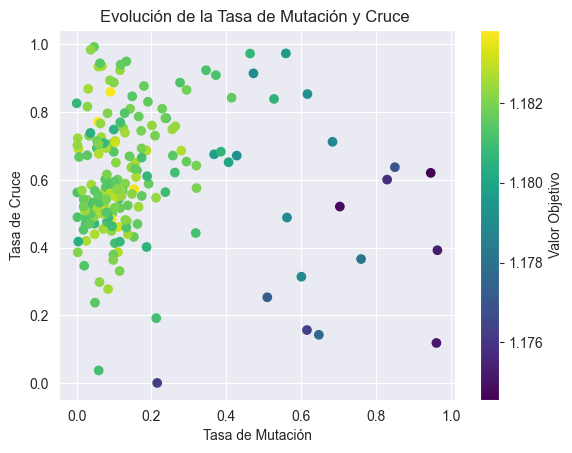

In [9]:
# Guarda el DataFrame en un archivo CSV
df.to_csv('study_results.csv', index=False)

import matplotlib.pyplot as plt
valor_objetivo = df.iloc[:,1]
tasa_mutacion = df.iloc[:,6]
tasa_cruce = df.iloc[:,5]

# Crear el gráfico de dispersión
plt.scatter(tasa_mutacion, tasa_cruce, c=valor_objetivo, cmap='viridis', marker='o')

# Añadir una barra de color
cbar = plt.colorbar()
cbar.set_label('Valor Objetivo')

# Etiquetas de los ejes
plt.xlabel('Tasa de Mutación')
plt.ylabel('Tasa de Cruce')

# Título del gráfico
plt.title('Evolución de la Tasa de Mutación y Cruce ')

# Mostrar el gráfico
plt.show()